## Imports

In [1]:
import sys
sys.path.append("../")

In [2]:
import cv2
from PIL import Image
from torchvision import transforms
import torch.nn.functional as F
import torch
import numpy as np

In [3]:
from options.test_options import TestOptions
from models.models import create_model
from insightface_func.face_detect_crop_single import Face_detect_crop

In [4]:
%load_ext autoreload
%autoreload 2

## Objective

Come up with a predict function that accepts 1 source image (in PIL format) and 1 reference image (in PIL format) and returns 1 output image (in PIL format)

__Inference__
```bash
python test_wholeimage_swapsingle.py --isTrain false  --name people \             
    --Arc_path arcface_model/arcface_checkpoint.tar --pic_a_path \                                                                         
    ./demo_file/Kianboon_cropped.jpg --pic_b_path ./demo_file/samurai_1.jpg --output_path ./output/

```

## Options & Constants

In [5]:
crop_size = 224

In [6]:
transformer_Arcface = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

In [13]:
def pil_to_cv2(img: Image.Image) -> np.array:
    return cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)

def cv2_to_pil(img: np.array) -> Image.Image:
    return Image.fromarray(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))

In [7]:
def _totensor(array):
    tensor = torch.from_numpy(array)
    img = tensor.transpose(0, 1).transpose(0, 2).contiguous()
    return img.float().div(255)

In [10]:
def reverse2wholeimage(swaped_imgs, mats, crop_size, oriimg) -> Image.Image:
    target_image_list = []
    img_mask_list = []
    for swaped_img, mat in zip(swaped_imgs, mats):
        swaped_img = swaped_img.cpu().detach().numpy().transpose((1, 2, 0))
        img_white = np.full((crop_size,crop_size), 255, dtype=float)

        # inverse the Affine transformation matrix
        mat_rev = np.zeros([2,3])
        div1 = mat[0][0]*mat[1][1]-mat[0][1]*mat[1][0]
        mat_rev[0][0] = mat[1][1]/div1
        mat_rev[0][1] = -mat[0][1]/div1
        mat_rev[0][2] = -(mat[0][2]*mat[1][1]-mat[0][1]*mat[1][2])/div1
        div2 = mat[0][1]*mat[1][0]-mat[0][0]*mat[1][1]
        mat_rev[1][0] = mat[1][0]/div2
        mat_rev[1][1] = -mat[0][0]/div2
        mat_rev[1][2] = -(mat[0][2]*mat[1][0]-mat[0][0]*mat[1][2])/div2

        orisize = (oriimg.shape[1], oriimg.shape[0])
        target_image = cv2.warpAffine(swaped_img, mat_rev, orisize)
        img_white = cv2.warpAffine(img_white, mat_rev, orisize)


        img_white[img_white>20] =255

        img_mask = img_white

        kernel = np.ones((10,10),np.uint8)
        img_mask = cv2.erode(img_mask,kernel,iterations = 1)

        img_mask /= 255

        img_mask = np.reshape(img_mask, [img_mask.shape[0],img_mask.shape[1],1])
        target_image = np.array(target_image, dtype=np.float)[..., ::-1] * 255

        img_mask_list.append(img_mask)
        target_image_list.append(target_image)
    # target_image /= 255
    # target_image = 0
    img = np.array(oriimg, dtype=np.float)
    for img_mask, target_image in zip(img_mask_list, target_image_list):
        img = img_mask * target_image + (1-img_mask) * img
        
    final_img = img.astype(np.uint8)
    final_img = cv2.cvtColor(final_img, cv2.COLOR_BGR2RGB)
    return Image.fromarray(final_img)

In [8]:
args = "--isTrain false  --name people --Arc_path ../arcface_model/arcface_checkpoint.tar --checkpoints_dir ../checkpoints"
args += " "
args += "--pic_a_path ../demo_file/Kianboon_cropped.jpg --pic_b_path ../demo_file/samurai_1.jpg --output_path ../output/"
args = args.split()

In [9]:
opt = TestOptions().parse(args=args)

------------ Options -------------
Arc_path: ../arcface_model/arcface_checkpoint.tar
aspect_ratio: 1.0
batchSize: 8
checkpoints_dir: ../checkpoints
cluster_path: features_clustered_010.npy
data_type: 32
dataroot: ./datasets/cityscapes/
display_winsize: 512
engine: None
export_onnx: None
feat_num: 3
fineSize: 512
fp16: False
gpu_ids: [0]
how_many: 50
id_thres: 0.03
image_size: 224
input_nc: 3
instance_feat: False
isTrain: False
label_feat: False
label_nc: 0
latent_size: 512
loadSize: 1024
load_features: False
local_rank: 0
max_dataset_size: inf
model: pix2pixHD
multisepcific_dir: ./demo_file/multispecific
nThreads: 2
n_blocks_global: 6
n_blocks_local: 3
n_clusters: 10
n_downsample_E: 4
n_downsample_global: 3
n_local_enhancers: 1
name: people
nef: 16
netG: global
ngf: 64
niter_fix_global: 0
no_flip: False
no_instance: False
no_simswaplogo: False
norm: batch
norm_G: spectralspadesyncbatch3x3
ntest: inf
onnx: None
output_nc: 3
output_path: ../output/
phase: test
pic_a_path: ../demo_file/Ki

## Model

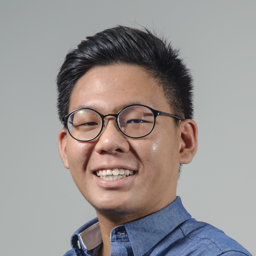

In [44]:
pic_a = opt.pic_a_path
im = Image.open(pic_a)
im.thumbnail((256,256))
im

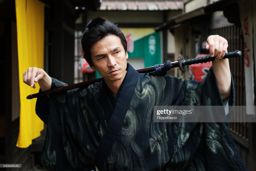

In [45]:
pic_b = opt.pic_b_path
im = Image.open(pic_b)
im.thumbnail((256,256))
im

In [24]:
model = create_model(opt)
model.eval()

/home/kianboonkoh/miniconda3/envs/simswap/lib/python3.6/site-packages/torch/serialization.py:658: SourceChangeWarning: source code of class 'torch.nn.parallel.data_parallel.DataParallel' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/kianboonkoh/miniconda3/envs/simswap/lib/python3.6/site-packages/torch/serialization.py:658: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/kianboonkoh/miniconda3/envs/simswap/lib/python3.6/site-packages/torch/serialization.py:658: SourceChangeWarning: source code of class 'torch.nn.modules.batchnorm.BatchNorm2d'

fsModel(
  (netG): Generator_Adain_Upsample(
    (first_layer): Sequential(
      (0): ReflectionPad2d((3, 3, 3, 3))
      (1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1))
      (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): ReLU(inplace=True)
    )
    (down1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (down2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (down3): Sequential(
      (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
 

In [27]:
app = Face_detect_crop(name='antelope', root='../insightface_func/models')

input mean and std: 127.5 127.5
find model: ../insightface_func/models/antelope/glintr100.onnx recognition
find model: ../insightface_func/models/antelope/scrfd_10g_bnkps.onnx detection


In [28]:
app.prepare(ctx_id= 0, det_thresh=0.6, det_size=(640,640))

set det-size: (640, 640)


In [40]:
img_a_whole = cv2.imread(pic_a)
img_a_align_crop, _ = app.get(img_a_whole,crop_size)
img_a_align_crop_pil = Image.fromarray(cv2.cvtColor(img_a_align_crop[0],cv2.COLOR_BGR2RGB)) 
img_a = transformer_Arcface(img_a_align_crop_pil)
img_id = img_a.view(-1, img_a.shape[0], img_a.shape[1], img_a.shape[2])

In [41]:
img_id = img_id.cuda()

In [43]:
#create latent id
img_id_downsample = F.interpolate(img_id, scale_factor=0.5)
latend_id = model.netArc(img_id_downsample)
latend_id = F.normalize(latend_id, p=2, dim=1)

/home/kianboonkoh/miniconda3/envs/simswap/lib/python3.6/site-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


__Forward Pass__

In [46]:
img_b_whole = cv2.imread(pic_b)

In [78]:
img_b_align_crop_list, b_mat_list = app.get(img_b_whole,crop_size)

In [79]:
swap_result_list = []

In [80]:
for b_align_crop in img_b_align_crop_list:

    b_align_crop_tenor = _totensor(cv2.cvtColor(b_align_crop,cv2.COLOR_BGR2RGB))[None,...].cuda()

    swap_result = model(None, b_align_crop_tenor, latend_id, None, True)[0]
    swap_result_list.append(swap_result)

/home/kianboonkoh/miniconda3/envs/simswap/lib/python3.6/site-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [82]:
%%time
im = reverse2wholeimage(swap_result_list, b_mat_list, crop_size, img_b_whole)

CPU times: user 188 ms, sys: 51.8 ms, total: 240 ms
Wall time: 54.4 ms


In [83]:
im.size

(1024, 683)

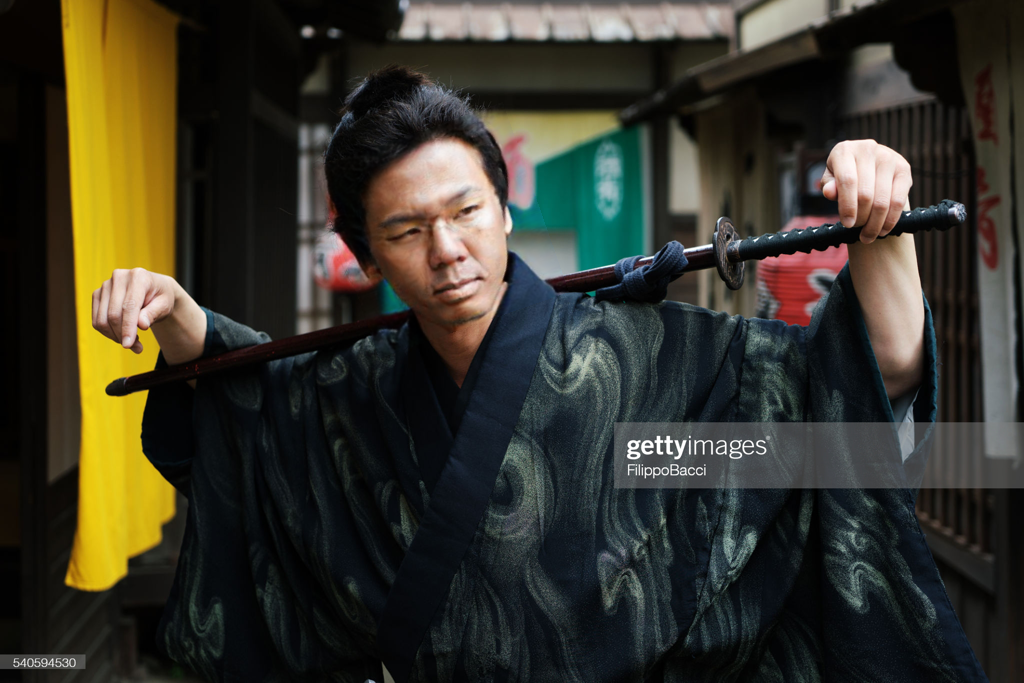

In [84]:
im

## Predict Function

Assume models are accessible through instance variables or global variables

In [11]:
model = create_model(opt)
model.eval()

/home/kianboonkoh/miniconda3/envs/simswap/lib/python3.6/site-packages/torch/serialization.py:658: SourceChangeWarning: source code of class 'torch.nn.parallel.data_parallel.DataParallel' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/kianboonkoh/miniconda3/envs/simswap/lib/python3.6/site-packages/torch/serialization.py:658: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/kianboonkoh/miniconda3/envs/simswap/lib/python3.6/site-packages/torch/serialization.py:658: SourceChangeWarning: source code of class 'torch.nn.modules.batchnorm.BatchNorm2d'

fsModel(
  (netG): Generator_Adain_Upsample(
    (first_layer): Sequential(
      (0): ReflectionPad2d((3, 3, 3, 3))
      (1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1))
      (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): ReLU(inplace=True)
    )
    (down1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (down2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (down3): Sequential(
      (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
 

In [12]:
app = Face_detect_crop(name='antelope', root='../insightface_func/models')
app.prepare(ctx_id= 0, det_thresh=0.6, det_size=(640,640))

input mean and std: 127.5 127.5
find model: ../insightface_func/models/antelope/glintr100.onnx recognition
find model: ../insightface_func/models/antelope/scrfd_10g_bnkps.onnx detection
set det-size: (640, 640)


In [27]:
def predict(src_img: Image.Image, ref_img: Image.Image) -> Image.Image:
    # process src_image
    src_img = pil_to_cv2(src_img)
    src_img_list, _ = app.get(src_img,crop_size)
    src_img = transformer_Arcface(cv2_to_pil(src_img_list[0]))
    src_img_id = src_img.view(-1, src_img.shape[0], src_img.shape[1], src_img.shape[2])
    src_img_id = src_img_id.cuda()    
    
    #create latent id
    src_img_id_downsample = F.interpolate(src_img_id, scale_factor=0.5)
    src_latend_id = model.netArc(src_img_id_downsample)
    src_latend_id = F.normalize(src_latend_id, p=2, dim=1)
    
    # process ref_img
    ref_img = pil_to_cv2(ref_img)
    ref_img_list, ref_mat_list = app.get(ref_img,crop_size)    
    
    # forward pass
    swap_result_list = []
    for i in ref_img_list:

        i_tensor = _totensor(cv2.cvtColor(i,cv2.COLOR_BGR2RGB))[None,...].cuda()

        swap_result = model(None, i_tensor, src_latend_id, None, True)[0]
        swap_result_list.append(swap_result)
    
    output = reverse2wholeimage(swap_result_list, ref_mat_list, crop_size, ref_img)
    return output

In [28]:
src_img = Image.open(opt.pic_a_path)

In [29]:
ref_img = Image.open(opt.pic_b_path)

In [30]:
%%time
output = predict(src_img, ref_img)

/home/kianboonkoh/miniconda3/envs/simswap/lib/python3.6/site-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/kianboonkoh/miniconda3/envs/simswap/lib/python3.6/site-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


CPU times: user 9.52 s, sys: 409 ms, total: 9.93 s
Wall time: 511 ms


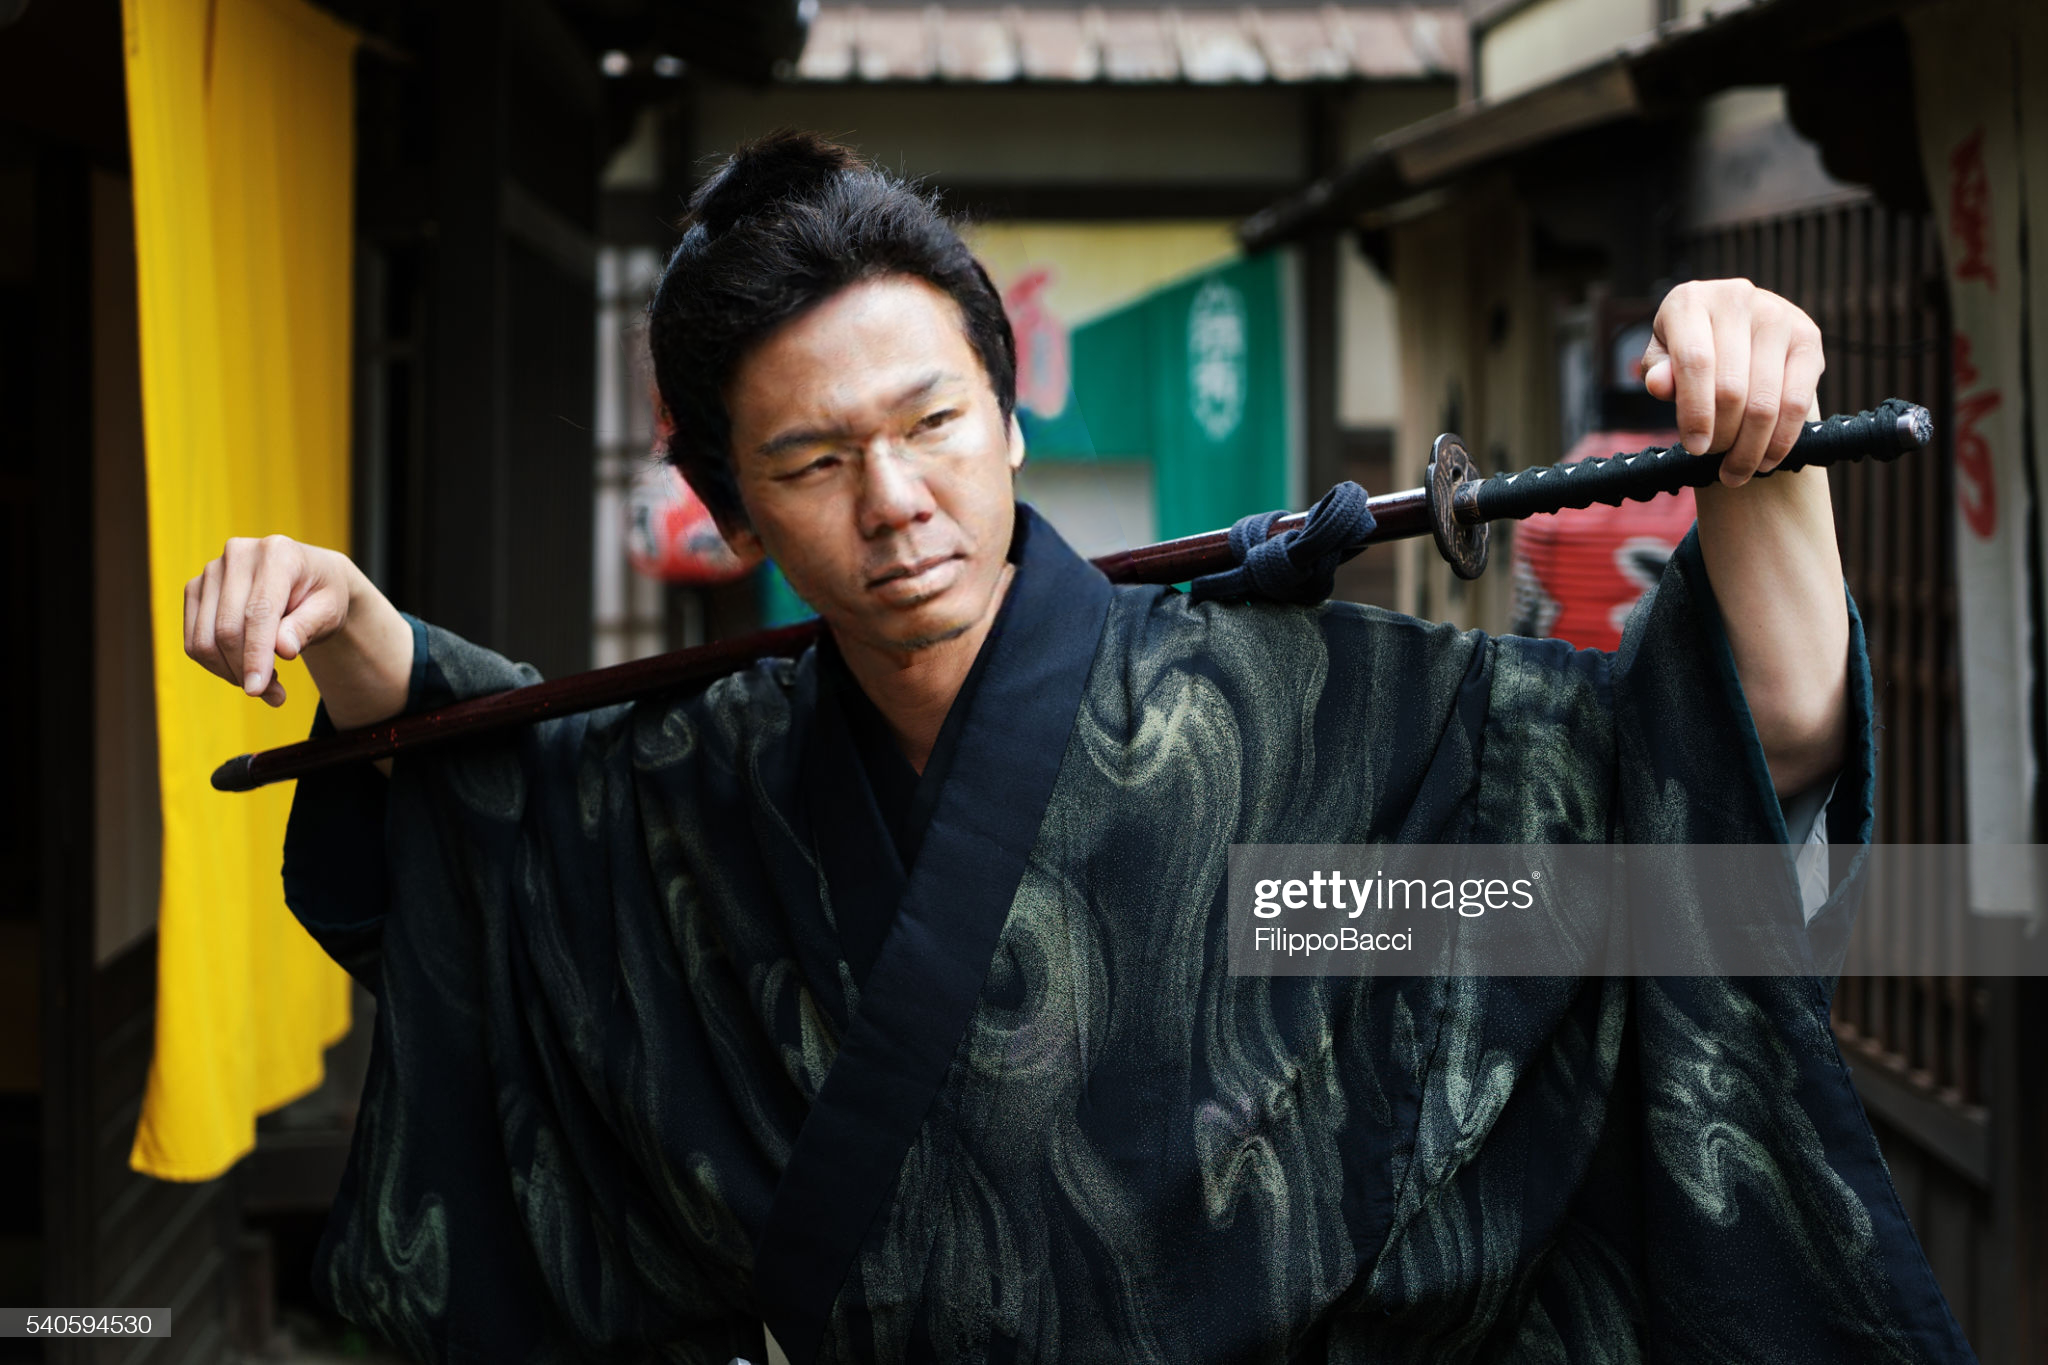

In [31]:
output